In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
import datetime
import operator 
plt.style.use('seaborn-poster')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import warnings
warnings.filterwarnings("ignore")
from PIL import ImageTk,Image 
from matplotlib.figure import Figure
import dataframe_image as dfi

In [2]:

confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
#recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/01-27-2022.csv')
us_medical_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/01-27-2022.csv')
#apple_mobility = pd.read_csv("https://covid19-static.cdn-apple.com/covid19-mobility-data/2206HotfixDev31/v3/en-us/applemobilitytrends-2022-01-27.csv")

In [3]:
latest_data.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio
0,NaN,NaN,NaN,Afghanistan,2022-01-28 04:21:09,33.93911,67.709953,161004,7403,NaN,NaN,Afghanistan,413.590705,4.598022
1,NaN,NaN,NaN,Albania,2022-01-28 04:21:09,41.15330,20.168300,252577,3323,NaN,NaN,Albania,8776.739176,1.315638
2,NaN,NaN,NaN,Algeria,2022-01-28 04:21:09,28.03390,1.659600,245698,6539,NaN,NaN,Algeria,560.301382,2.661397
3,NaN,NaN,NaN,Andorra,2022-01-28 04:21:09,42.50630,1.521800,35028,145,NaN,NaN,Andorra,45334.886430,0.413955
4,NaN,NaN,NaN,Angola,2022-01-28 04:21:09,-11.20270,17.873900,97901,1893,NaN,NaN,Angola,297.876838,1.933586


In [4]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/3/22,2/4/22,2/5/22,2/6/22,2/7/22,2/8/22,2/9/22,2/10/22,2/11/22,2/12/22
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,164727,165358,165711,166191,166924,167739,168550,169448,169940,170152
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,261240,263172,263172,264624,264875,265716,266416,267020,267020,267551
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,255836,256806,257598,257976,258478,259088,259673,260191,260723,261226
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,36470,36599,36599,36599,36808,36808,36989,37074,37140,37140
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,98319,98340,98351,98364,98409,98424,98453,98474,98501,98514


In [5]:
cols = confirmed_df.keys()

In [6]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
# recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

In [7]:

dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
# recovery_rate = [] 
# total_recovered = [] 
# total_active = [] 

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
#     recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
#     total_recovered.append(recovered_sum)
#     total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)
#     recovery_rate.append(recovered_sum/confirmed_sum)

In [8]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

def moving_average(data, window_size):
    moving_average = []
    for i in range(len(data)):
        if i + window_size < len(data):
            moving_average.append(np.mean(data[i:i+window_size]))
        else:
            moving_average.append(np.mean(data[i:len(data)]))
    return moving_average

# window size
window = 7

# confirmed cases
world_daily_increase = daily_increase(world_cases)
world_confirmed_avg= moving_average(world_cases, window)
world_daily_increase_avg = moving_average(world_daily_increase, window)

# deaths
world_daily_death = daily_increase(total_deaths)
world_death_avg = moving_average(total_deaths, window)
world_daily_death_avg = moving_average(world_daily_death, window)


# recoveries
# world_daily_recovery = daily_increase(total_recovered)
# world_recovery_avg = moving_average(total_recovered, window)
# world_daily_recovery_avg = moving_average(world_daily_recovery, window)


# active 
# world_active_avg = moving_average(total_active, window)


In [9]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
# total_recovered = np.array(total_recovered).reshape(-1, 1)

In [10]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

In [11]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [12]:
# slightly modify the data to fit the model better (regression models cannot pick the pattern)
days_to_skip = 376
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22[days_to_skip:], world_cases[days_to_skip:], test_size=0.08, shuffle=False)

In [13]:
# # use this to find the optimal parameters for SVR
# c = [0.01, 0.1, 1]
# gamma = [0.01, 0.1, 1]
# epsilon = [0.01, 0.1, 1]
# shrinking = [True, False]

# svm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking}

# svm = SVR(kernel='poly', degree=3)
# svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
# svm_search.fit(X_train_confirmed, y_train_confirmed)

In [14]:
# svm_search.best_params_

In [15]:
# svm_confirmed = svm_search.best_estimator_
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

MAE: 46941884.517555185
MSE: 2588155879080822.0


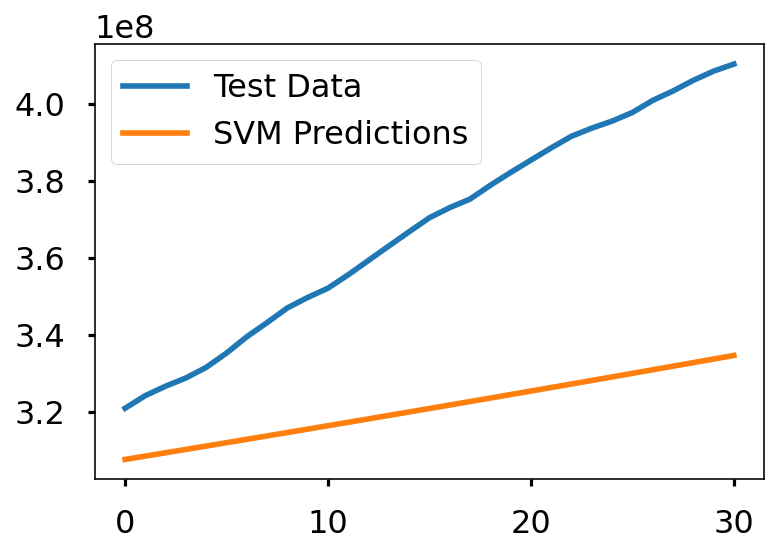

In [16]:
# check against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

In [17]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=2)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

bayesian_poly = PolynomialFeatures(degree=2)
bayesian_poly_X_train_confirmed = bayesian_poly.fit_transform(X_train_confirmed)
bayesian_poly_X_test_confirmed = bayesian_poly.fit_transform(X_test_confirmed)
bayesian_poly_future_forcast = bayesian_poly.fit_transform(future_forcast)

In [18]:
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 66806136.09133296
MSE: 4972972730291462.0


In [19]:
print(linear_model.coef_)

[[-9.50831341e+07  5.08430745e+05  3.94609934e+01]]


In [20]:
accuracy = r2_score(test_linear_pred, y_test_confirmed)
accuracy

-192.6326397097631

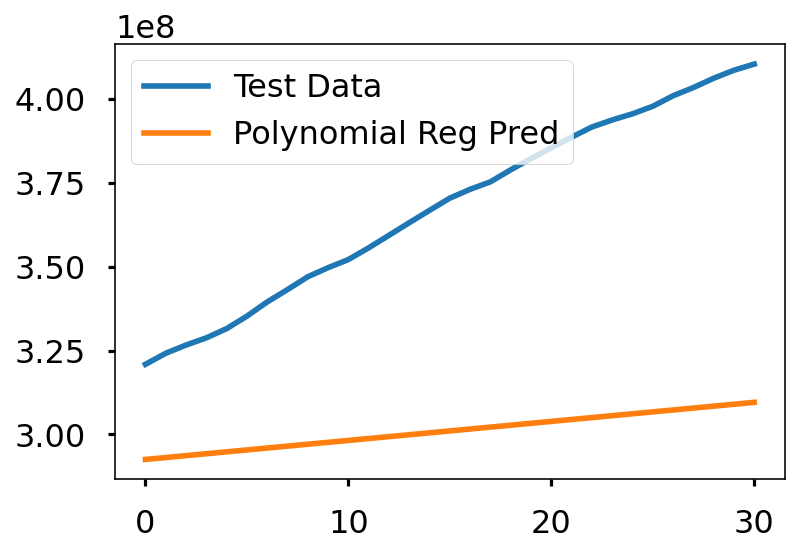

In [21]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Reg Pred'])

In [22]:
# bayesian ridge polynomial regression
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
normalize = [True, False]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2, 
                 'normalize' : normalize}

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(bayesian_poly_X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.9s finished


RandomizedSearchCV(cv=3, estimator=BayesianRidge(fit_intercept=False),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                     0.0001, 0.001],
                                        'lambda_2': [1e-07, 1e-06, 1e-05,
                                                     0.0001, 0.001],
                                        'normalize': [True, False],
                                        'tol': [1e-06, 1e-05, 0.0001, 0.001,
                                                0.01]},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [23]:
bayesian_search.best_params_

{'tol': 1e-06,
 'normalize': True,
 'lambda_2': 0.0001,
 'lambda_1': 1e-07,
 'alpha_2': 1e-07,
 'alpha_1': 0.0001}

In [24]:

bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(bayesian_poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(bayesian_poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 59460660.95313732
MSE: 4000239570922330.0


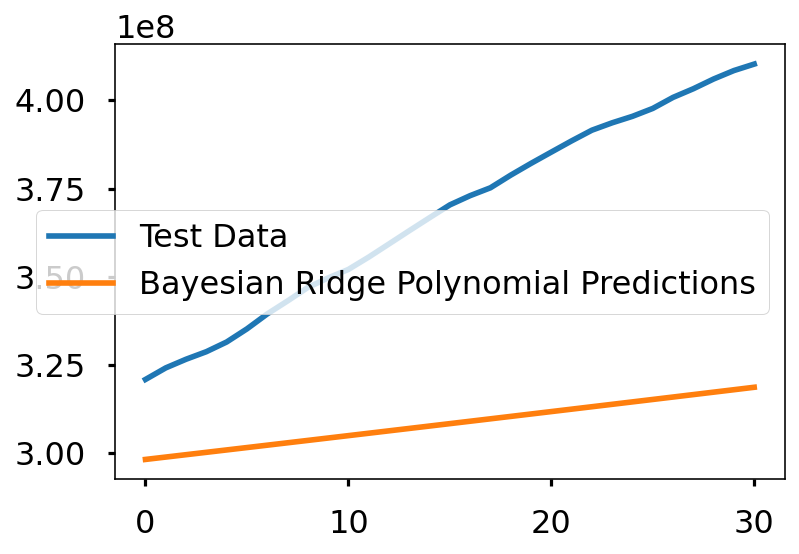

In [25]:
plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)
plt.legend(['Test Data', 'Bayesian Ridge Polynomial Predictions'])

In [26]:
def plot_predictions(x, y, pred, algo_name, color):
    plt.figure(figsize=(16, 10))
    plt.plot(x, y)
    plt.plot(future_forcast, pred, linestyle='dashed', color=color)
    plt.title('Worldwide Coronavirus Cases Over Time', size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.legend(['Confirmed Cases', algo_name], prop={'size': 20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()
    

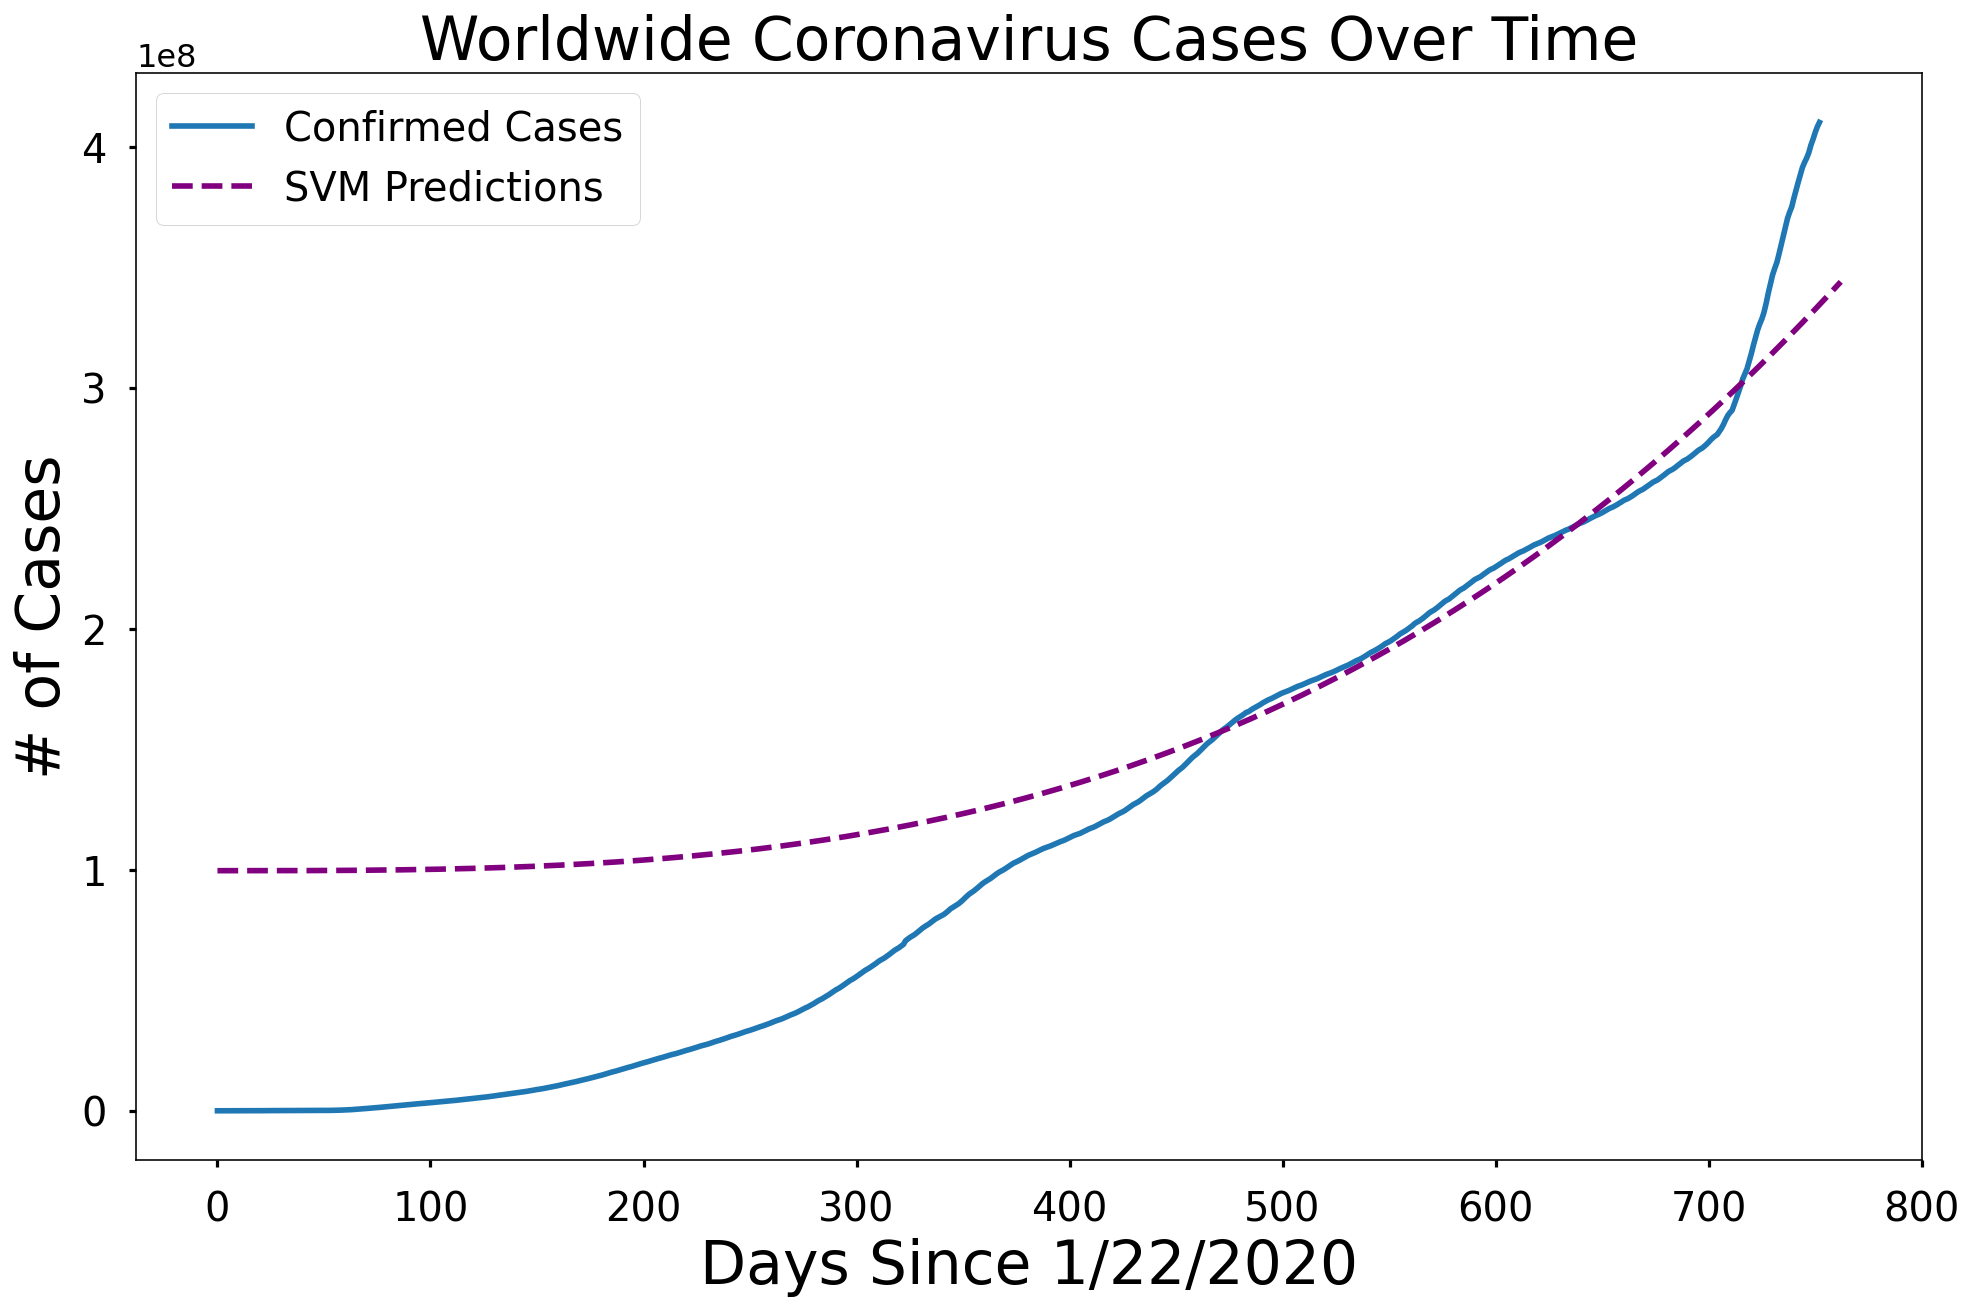

In [27]:
plot_predictions(adjusted_dates, world_cases, svm_pred, 'SVM Predictions', 'purple')


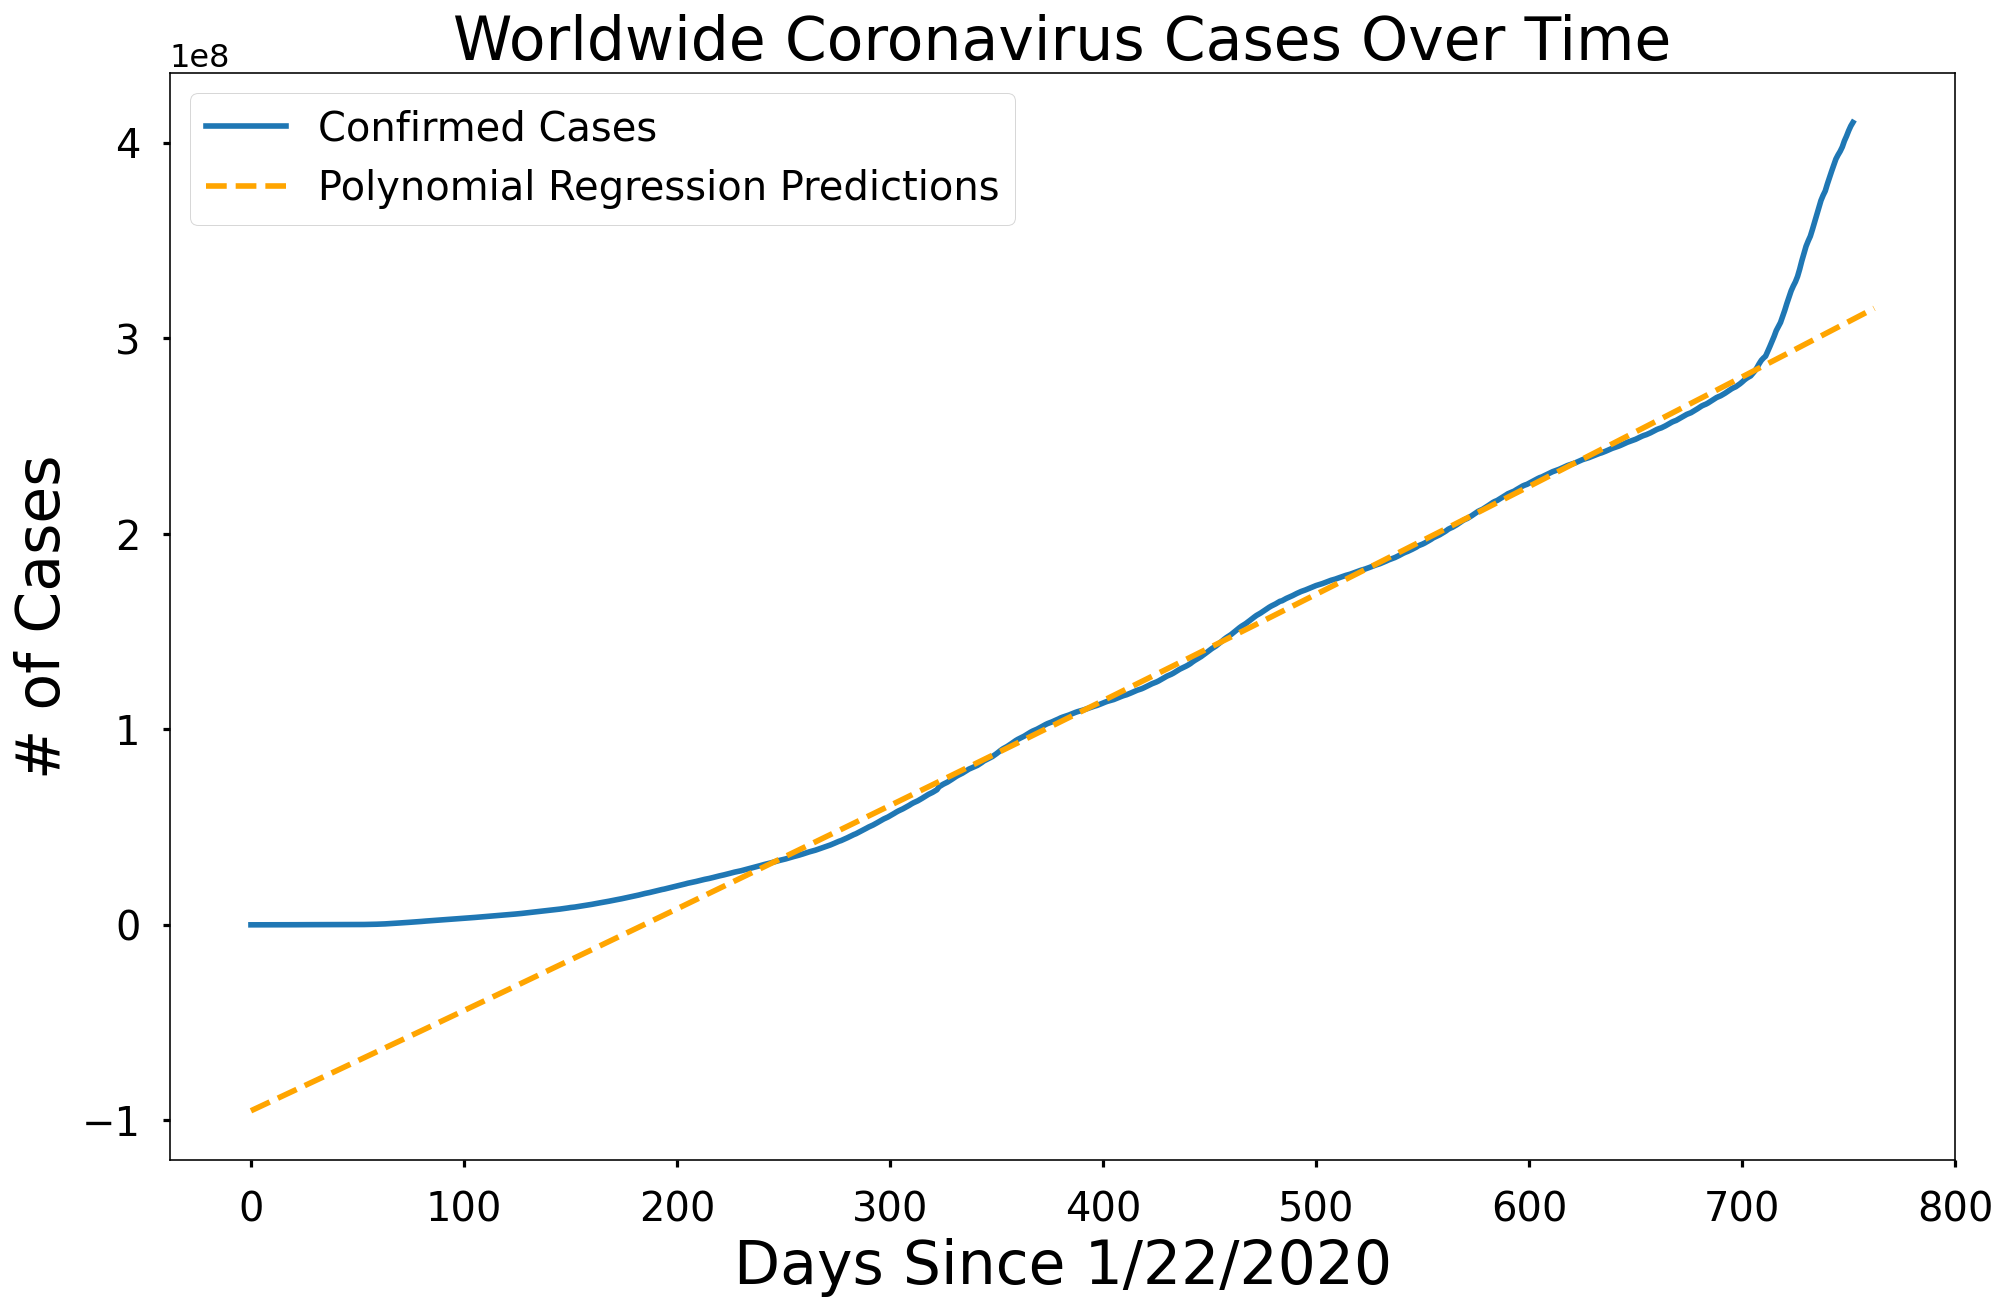

In [28]:
plot_predictions(adjusted_dates, world_cases, linear_pred, 'Polynomial Regression Predictions', 'orange')

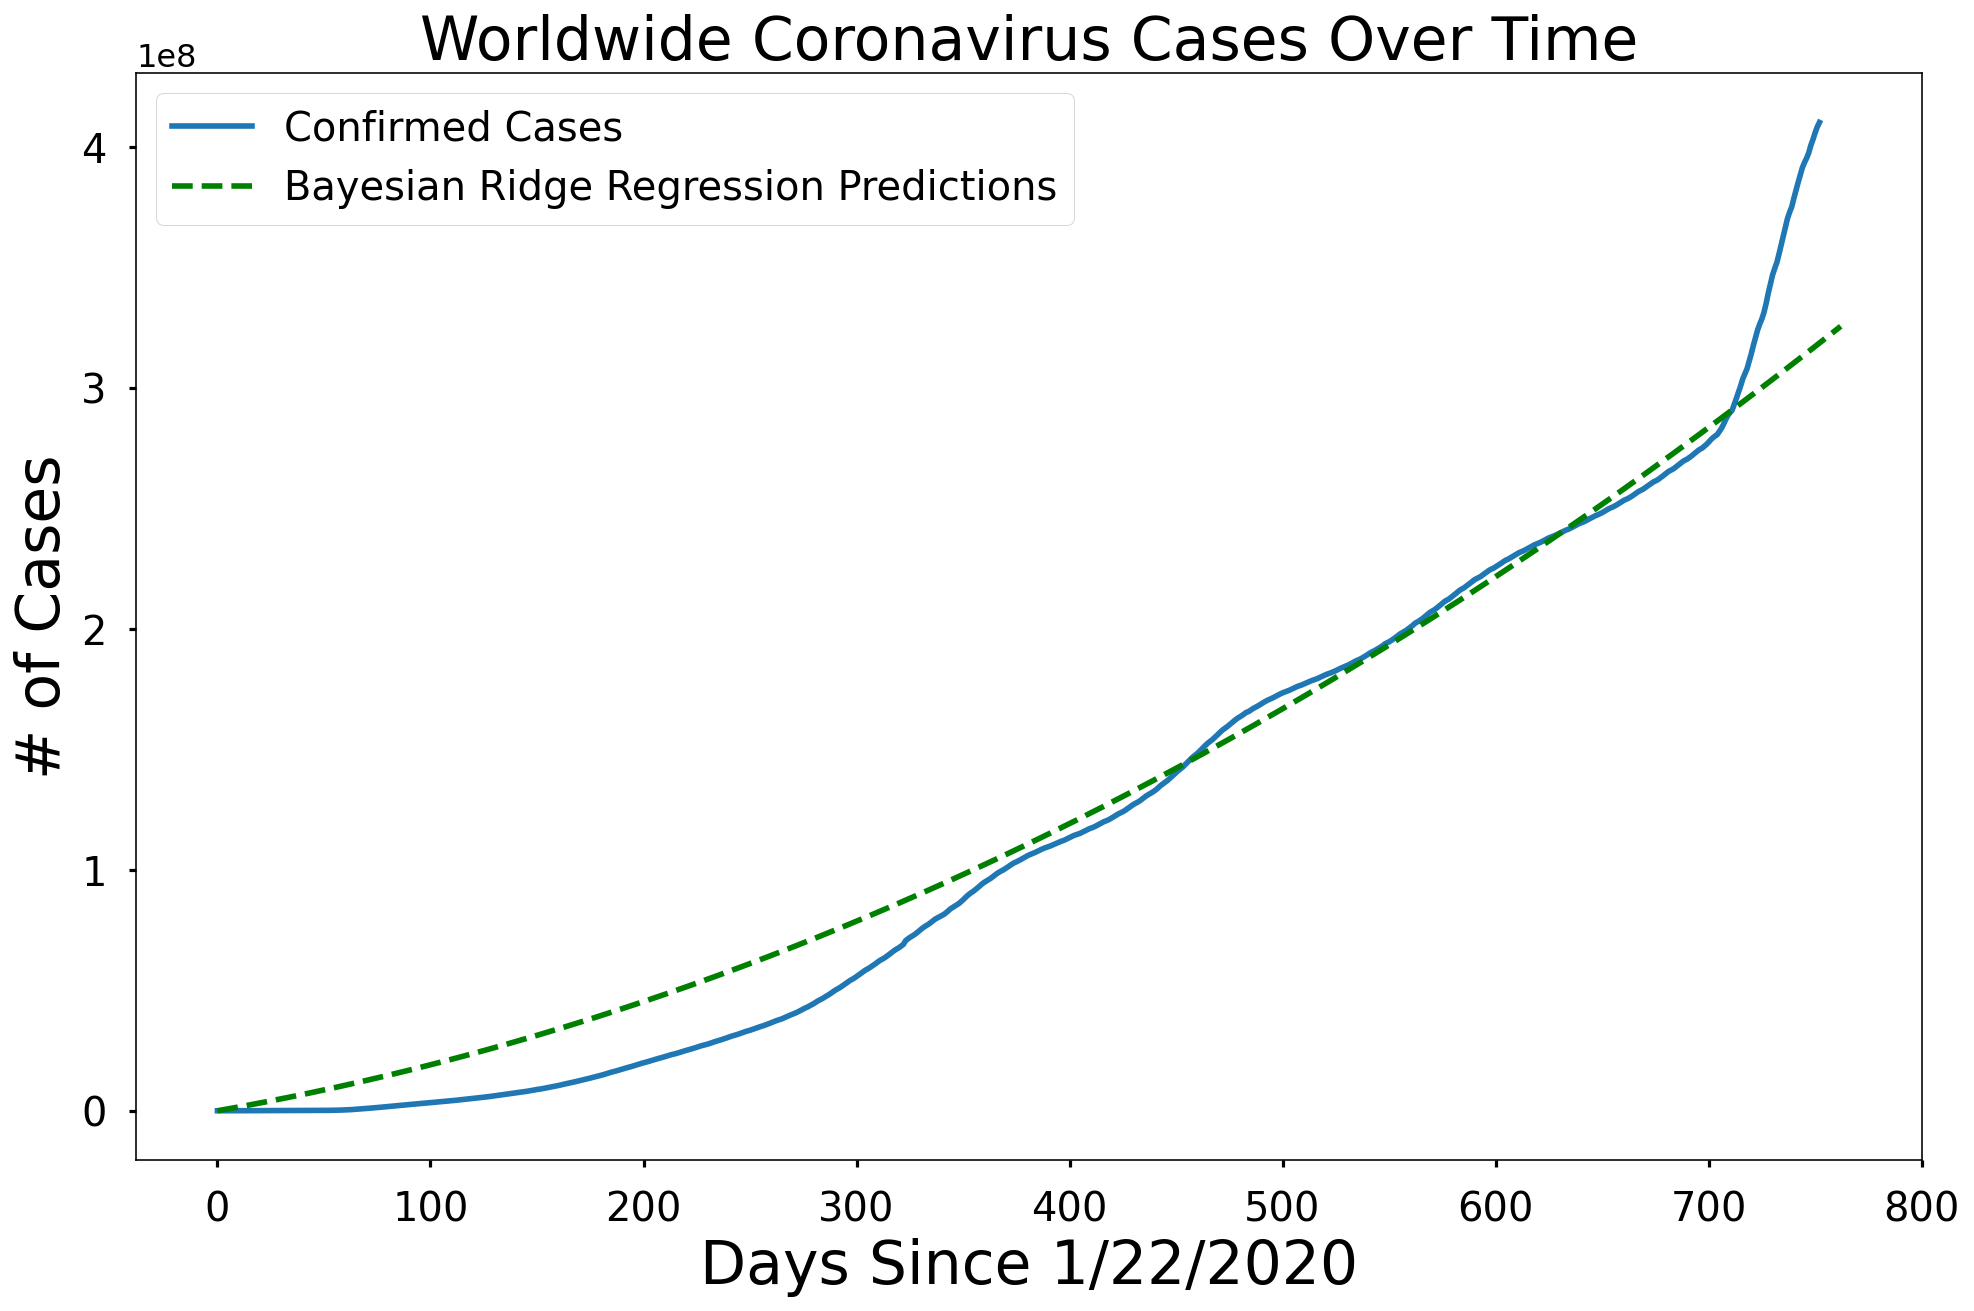

In [29]:
plot_predictions(adjusted_dates, world_cases, bayesian_pred, 'Bayesian Ridge Regression Predictions', 'green')

In [30]:
# Future predictions using SVM 
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'SVM Predicted # of Confirmed Cases Worldwide': np.round(svm_pred[-10:])})
svm_df.style.background_gradient(cmap='Reds')

,Date,SVM Predicted # of Confirmed Cases Worldwide
0,02/13/2022,335553039.000000
1,02/14/2022,336494055.000000
2,02/15/2022,337437570.000000
3,02/16/2022,338383588.000000
4,02/17/2022,339332111.000000
5,02/18/2022,340283144.000000
6,02/19/2022,341236690.000000
7,02/20/2022,342192751.000000
8,02/21/2022,343151332.000000
9,02/22/2022,344112435.000000


In [82]:
df_styled = svm_df.style.background_gradient(cmap='Reds')
dfi.export(df_styled,"svm2.png")

In [31]:
# Future predictions using polynomial regression
linear_pred = linear_pred.reshape(1,-1)[0]
linear_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Polynomial Predicted # of Confirmed Cases Worldwide': np.round(linear_pred[-10:])})
linear_df.style.background_gradient(cmap='Reds')

,Date,Polynomial Predicted # of Confirmed Cases Worldwide
0,02/13/2022,310139955.000000
1,02/14/2022,310707854.000000
2,02/15/2022,311275831.000000
3,02/16/2022,311843887.000000
4,02/17/2022,312412023.000000
5,02/18/2022,312980237.000000
6,02/19/2022,313548530.000000
7,02/20/2022,314116902.000000
8,02/21/2022,314685353.000000
9,02/22/2022,315253882.000000


In [89]:
lineardf_styled = linear_df.style.background_gradient(cmap='Reds')
dfi.export(lineardf_styled,"pol2.png")

In [32]:
# Future predictions using Bayesian Ridge 
bayesian_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Bayesian Ridge Predicted # of Confirmed Cases Worldwide': np.round(bayesian_pred[-10:])})
bayesian_df.style.background_gradient(cmap='Reds')

,Date,Bayesian Ridge Predicted # of Confirmed Cases Worldwide
0,02/13/2022,319382855.000000
1,02/14/2022,320076332.000000
2,02/15/2022,320770524.000000
3,02/16/2022,321465430.000000
4,02/17/2022,322161050.000000
5,02/18/2022,322857385.000000
6,02/19/2022,323554434.000000
7,02/20/2022,324252197.000000
8,02/21/2022,324950675.000000
9,02/22/2022,325649867.000000


In [91]:
bayesiandf_styled = bayesian_df.style.background_gradient(cmap='Reds')
dfi.export(bayesiandf_styled,"bay2.png")

In [37]:
from tkinter import *
from tkhtmlview import HTMLLabel
import tkinter.ttk as ttk
import tkinter as tk
import sqlite3
from tkinter import messagebox
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("TkAgg")
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg


def create():  
    
    con = sqlite3.connect('D:/Tejitha/hobby project/DB.db')
    cur = con.cursor()      
    cur.execute("create table if not exists login(username varchar(20) PRIMARY KEY, password varchar(20), name varchar(50))")
    con.commit()
    con.close()
def create_admin():
    global flag
    con = sqlite3.connect('D:/Tejitha/hobby project/DB.db')
    cur = con.cursor()
    cur.execute("select * from login where username='admin'")
    status = cur.fetchall()
    if (len(status))==0:
        cur.execute("insert into login values ('admin', 'admin', 'Administrator')")
    else:
        flag=0
    con.commit()
    con.close()

def sign_in(index_ui,username, password):
    global showerror

    con = sqlite3.connect('D:/Tejitha/hobby project/DB.db')
    cur = con.cursor()
    try:
        cur.execute("select count(*) from login where username=? and password=?", (username, password))
    except:
        messagebox.showerror('ERROR', 'SIGNIN FAILED')
        
        
    status = cur.fetchall()
    if status[0][0]==1:
        index_ui.destroy()
        dashboard(username)
    else:
        messagebox.showerror('ERROR', 'SIGNING FAILED')
    
    con.commit()
    con.close()

def create_acc():
    global lb19,lb20,lb21,lb22,lb23
    create_win = tk.Toplevel()
    create_win.geometry("1280x720")
#    create_win.resizable(0,0)
    
    new_user_bg = tk.PhotoImage(file="D:/Tejitha/hobby project/Images/other_bg.gif")
    lb19=tk.Label(create_win, image=new_user_bg).place(x=0, y=0)
    lb20=tk.Label(create_win, text="CREATE AN ACCOUNT", font="Helvetica 15 bold", fg='white', bg='#34383C').place(x=331, y=60)

    username = tk.Entry(create_win, font=(13))
    lb21=tk.Label(create_win, text='Username', fg = '#34383C', bg='white', font='Helvetica 11 bold').place(x=300, y=160)
        
    password = tk.Entry(create_win, font=(13))
    lb22=tk.Label(create_win, text='Password', fg = '#34383C', bg='white',font='Helvetica 11 bold').place(x=300, y=260)
        
    name = tk.Entry(create_win, font=(13))
    lb23=tk.Label(create_win, text='Name', fg = '#34383C', bg='white', font='Helvetica 11 bold').place(x=300, y=360)

        
    username.place(x=300, y=200)
    password.place(x=300, y=300)
    name.place(x=300, y=400)
  

    tk.Button(create_win, text=' '*20+' SUBMIT'+' '*22, bg='#00BC90', fg='#34383C',font='Helvetica 15' ,borderwidth=0, command=lambda:submit()).place(x=270, y=490)
    def submit():
        conn=sqlite3.connect('D:/Tejitha/hobby project/DB.db')
         #Create Cursor
        cur=conn.cursor()
        try:
            cur.execute("insert into login values(?,?,?)", (username.get(), password.get(), name.get()))
            messagebox.showinfo("CREATED", "ACCOUNT CREATED, NOW YOU CAN LOG IN TO THE APPLICATION")
            
        except:
            messagebox.showerror("ERROR", "YOUR ACCOUNT IS PROBABLY ALREADY REGISTERED , TRY LOGGING IN AND IF THE PROBLEM PERSISTS SEE HELP MENU")
        conn.commit()
        conn.close()
            
    create_win.mainloop()

#DASHBOARD
def dashboard(username):
    global lb27,lb28,lb29,lb30,lb31,lb32,lb33,lb34,lb35,lb53,l101,l102,l103,l104,l135,l136,l137,l138,l139,l140
    dash_ui =tk.Tk()
    dash_ui.geometry("1280x720")
#    dash_ui.resizable(0,0)
    bg = tk.PhotoImage(file="D:/Tejitha/hobby project/Images/dashboard_bg.gif")
    lb27=tk.Label(dash_ui, relief="flat",image=bg).grid(row=0, column=0, rowspan=20, columnspan=20)

    #user_bg = tk.PhotoImage(file="D:/Tejitha/hobby project/Images/user.gif")
    #lb28=tk.Label(dash_ui, image=user_bg,borderwidth=0).place(x=800 , y=6.5)
    
    logout = tk.Button(dash_ui,bg='#16202C', borderwidth=0, command=lambda:dash_ui.destroy())
    logout_bg = tk.PhotoImage(file="D:/Tejitha/hobby project/Images/logout.gif")
    logout.config(image=logout_bg)
    logout.place(x=1200, y=10)
    lb29=tk.Label(dash_ui, text='DASHBOARD',fg='white',bg='#34383C', font='Helvetica 18 bold').place(x=45, y=50)
    lb30=tk.Label(dash_ui, text='WELCOME '+username.upper() , bg='#34383C', fg='#ffffff', font = 'Helvetica 30 bold').place(x=540, y=10)
       
        
    graph = tk.PhotoImage(file="D:/Tejitha/hobby project/Images/graph.gif")
    lb35=tk.Label(dash_ui, image=graph, borderwidth=0).place(x=400,y=150)
    
    
    vaccanal_bg= tk.PhotoImage(file="D:/Tejitha/hobby project/Images/vaccanal.gif")
    l102=tk.Label(dash_ui, bg='#16202C', borderwidth=0,image=vaccanal_bg).place(x=10, y=105)
    tk.Button(dash_ui, text='VACCINATION ANALYSIS', bg='#34383C', fg='#ffffff', font='4', 
              borderwidth=0,command=lambda:anal()).place(x=84, y=105)
    
    anal_bg= tk.PhotoImage(file="D:/Tejitha/hobby project/Images/anal.gif")
    l103=tk.Label(dash_ui, bg='#16202C', borderwidth=0,image=anal_bg).place(x=8.4,y=155)
    tk.Button(dash_ui, text='COVID-19 CASES PREDICTION', bg='#34383C', fg='#ffffff', font='4', 
              borderwidth=0,command=lambda:predi()).place(x=84, y=156)
    
              

    add_user = tk.Button(dash_ui,borderwidth=0,bg='#16202C', command=create_acc)
    add_user_bg = tk.PhotoImage(file="D:/Tejitha/hobby project/Images/add_user.gif")
    add_user.config(image=add_user_bg)
    add_user.place(x=1100, y=4)


    
   

    dash_ui.mainloop()
   
    
def anal():
        an_ui=tk.Toplevel()
        l141=tk.Label(an_ui, text='VACCINATION ANALYSIS', font=('times',29,'bold'),fg='black').place(x=100, y=50)
        l136 = HTMLLabel(an_ui,html='<a href ="D:/Question1.html">1. Which country is using what vaccine or What vaccines are used and in which countries?</a>').place(x=84,y=156)
        l137 = HTMLLabel(an_ui,html='<a href ="D:/Question2.html">2. What is the vaccine distribution? Are there any decreases in the number of cases in the countries that begin the vaccination process?</a>').place(x=84,y=250)
        l138 = HTMLLabel(an_ui,html='<a href ="D:/Question3.html">3. In which country the vaccination programme is more advanced?</a>').place(x=84,y=350)
        l139 = HTMLLabel(an_ui,html='<a href ="D:/Question4.html">4. After the beginning of the vaccine process all around the world, how the infection trend moves?</a>').place(x=84,y=450)
        #l140 = HTMLLabel(an_ui,html='<a href ="D:/Question5.html">5. Are there any correlations between the factors of development indicators and the numbers of vaccinations?</a>').place(x=84,y=550)
        #poster1 = tk.PhotoImage(file="D:/Tejitha/hobby project/Images/poster1.gif")
        #l101=tk.Label(an_ui, image=poster1, borderwidth=0).place(x=540,y=95)
        an_ui.mainloop()
    
def predi():
        global l105,l142,l143,l144,l145
        pred_ui=tk.Toplevel()
        l141=tk.Label(pred_ui, text='COVID-19 CASES PREDICTION', font=('times',29,'bold'),fg='black').place(x=50, y=50)
        l105=tk.Label(pred_ui,borderwidth=0).place(x=540,y=95)
        tk.Button(pred_ui, text='GRAPH BY SUPPORT VECTOR REGRESSION', bg='#34383C', fg='#ffffff', font='4', 
                  borderwidth=0,command=lambda:svmpredi()).place(x=200, y=156)
        tk.Button(pred_ui, text='GRAPH BY POLYNOMIAL REGRESSION', bg='#34383C', fg='#ffffff', font='4', 
                  borderwidth=0,command=lambda:polpredi()).place(x=200, y=256)
        tk.Button(pred_ui, text='GRAPH BY BAYESIAN RIDGE REGRESSION', bg='#34383C', fg='#ffffff', font='4', 
                  borderwidth=0,command=lambda:baypredi()).place(x=200, y=356)
        def svmpredi():
            plot_predictions(adjusted_dates, world_cases, svm_pred, 'SVM Predictions', 'purple')
            # Future predictions using SVM 
            canvas = FigureCanvasTkAgg(self)
            canvas.show()
            canvas.get_tk_widget.pack(side=BOTTOM, fill=BOTH,expland=True)
        def polpredi():
            plot_predictions(adjusted_dates, world_cases, linear_pred, 'Polynomial Regression Predictions', 'orange')            # Future predictions using SVM 
            canvas = FigureCanvasTkAgg(self)
            canvas.show()
            canvas.get_tk_widget.pack(side=BOTTOM, fill=BOTH,expland=True)
        def baypredi():
            plot_predictions(adjusted_dates, world_cases, bayesian_pred, 'Bayesian Ridge Regression Predictions', 'green')
            canvas = FigureCanvasTkAgg(self)
            canvas.show()
            canvas.get_tk_widget.pack(side=BOTTOM, fill=BOTH,expland=True)
        tk.Button(pred_ui, text='PREDICT USING SUPPORT VECTOR REGRESSION TECHNIQUE', bg='#34383C', fg='#ffffff', font='4', 
                  borderwidth=0,command=lambda:svmtable()).place(x=200, y=450)
        tk.Button(pred_ui, text='PREDICT USING POLYNOMIAL REGRESSION TECHNIQUE', bg='#34383C', fg='#ffffff', font='4', 
                  borderwidth=0,command=lambda:poltable()).place(x=200, y=525)
        tk.Button(pred_ui, text='PREDICT USING BAYESIAN RIDGE REGRESSION TECHNIQUE', bg='#34383C', fg='#ffffff', font='4', 
                  borderwidth=0,command=lambda:baytable()).place(x=200, y=600)
        def svmtable():
            global l78, l79,l80
            tab_ui=tk.Toplevel()
            l78=tk.Label(tab_ui, text='SUPPORT VECTOR REGRESSION TECHNIQUE', font=('times',29,'bold'),fg='black').place(x=100, y=50)
            svm = tk.PhotoImage(file="D:/svm2.png")
            l145=tk.Label(tab_ui, image=svm, borderwidth=0).place(x=280,y=150)
            tab_ui.mainloop()
        def poltable():
            tab_ui=tk.Toplevel()
            l79=tk.Label(tab_ui, text='POLYNOMIAL REGRESSION TECHNIQUE', font=('times',29,'bold'),fg='black').place(x=100, y=50)
            pol = tk.PhotoImage(file="D:/pol2.png")
            l143=tk.Label(tab_ui, image=pol, borderwidth=0).place(x=280,y=150)
            tab_ui.mainloop()
        def baytable():
            tab_ui=tk.Toplevel()
            l80=tk.Label(tab_ui, text='BAYESIAN RIDGE REGRESSION TECHNIQUE', font=('times',29,'bold'),fg='black').place(x=100, y=50)
            bay = tk.PhotoImage(file="D:/bay2.png")
            l144=tk.Label(tab_ui, image=bay, borderwidth=0).place(x=280,y=150)
            tab_ui.mainloop()
        pred_ui.mainloop()

In [38]:
from tkinter import *
import sqlite3
import tkinter.ttk as ttk
import tkinter as tk
from tkinter import messagebox

#LOGIN PAGE
create()
create_admin()


def index():
    global lb36,lb37,lb38,lb39,lb40,lb41,lb42,lb43,lb44,lb45,lb46,lb77
    index_ui =tk.Tk()
    index_ui.geometry("1280x720")
    index_ui.configure(background = "#FFC8FB")
#    index_ui.resizable(0,0)
#    bg =tk.PhotoImage(file="D:/Tejitha/hobby project/Images/Images/background.gif")
#    lb36=tk.Label(index_ui,image=bg).grid(row=0, column=0, rowspan=80, columnspan=80)

#    lb37=tk.Label(index_ui, text='Welcome', font='Helvetica 18 ', fg='black', bg='white').place(x=10, y=10)
    lb38=tk.Label(index_ui, text='VACCINATION ANALYSIS AND PREDICTION OF COVID-19', font=('times',29,'bold'),fg='black').place(x=50, y=10)
    lb77=tk.Label(index_ui, text='USING MACHINE LEARNING TECHNIQUES', font=('times',29,'bold'),fg='black').place(x=200, y=50)
    #    message3 =tk.Label(window, text="STUDENT PERFORMANCE PREDICTION" ,fg="black",bg="white" ,width=55 ,height=1,font=('times', 29, ' bold '))
#message3.place(x=10, y=10)
    #    lb39=tk.Label(index_ui, text='Add / Remove / update and view the records using this interactive application', font='Helvetica 10', fg='black', bg='white').place(x=50, y=290)
#    lb40=tk.Label(index_ui, text='Reduced function calls, improved speed', font='Helvetica 10', fg='#0D90CB', bg='#34383C').place(x=50, y=310)
#    lb41=tk.Label(index_ui, text='Code made readable for further developement', font='Helvetica 10', fg='#0D90CB', bg='#34383C').place(x=50, y=330)
    lb45=tk.Label(index_ui, text='IF YOU ARE A FIRST TIME USER, REGISTER BY CLICKING THE ICON', font=('times',15,'bold'),fg='black').place(x=50, y=500)
    lb45=tk.Label(index_ui, text='WANT TO KNOW MORE, CLICK THE ICON', font=('times',15,'bold'),fg='black').place(x=50, y=600)

    
    logo = tk.PhotoImage(file="D:/Tejitha/hobby project/Images/logo.gif")
    lb42=tk.Label(index_ui, image=logo,borderwidth=0).place(x=640,y=120)


    username_logo = tk.PhotoImage(file="D:/Tejitha/hobby project/Images/username_logo.gif")
    lb43=tk.Label(index_ui, image=username_logo).place(x=600, y=260)
    username = tk.Entry(index_ui, font=(14),fg='#0B8FCC')
    username.place(x=635, y=260)

    pass_logo = tk.PhotoImage(file="D:/Tejitha/hobby project/Images/password_logo.gif")
    lb44=tk.Label(index_ui, image=pass_logo).place(x=600, y=290)
    password = tk.Entry(index_ui, font=(14), show='*',fg='#0B8FCC')
    password.place(x=635, y=290)

    login_button = tk.Button(index_ui, borderwidth=0,bg='#1A2E39',command=lambda:sign_in(index_ui,username.get(), password.get()))
    login_button_bg = tk.PhotoImage(file="D:/Tejitha/hobby project/Images/login_button.GIF")
    login_button.config(image=login_button_bg)
    login_button.place(x=635 , y=370)

    help_button = tk.Button(index_ui, borderwidth=0, command=show_help,bg='#00BC90')
    help_bg = tk.PhotoImage(file="D:/Tejitha/hobby project/Images/help.gif")
    help_button.config(image=help_bg)
    help_button.place(x=500, y=600)
    
    add_user = tk.Button(index_ui,borderwidth=0,bg='#16202C', command=create_acc)
    add_user_bg = tk.PhotoImage(file="D:/Tejitha/hobby project/Images/add_user.gif")
    add_user.config(image=add_user_bg)
    add_user.place(x=750, y=470)
                      
    index_ui.mainloop()

def show_help():
    global lb45,lb46,lb47,lb48,lb49,lb50,lb51
    help_win = tk.Toplevel()
    help_win.geometry("1280x720")
#    help_win.resizable(0,0)

    help_win_bg = tk.PhotoImage(file="D:/Tejitha/hobby project/Images/other_bg.gif")
    lb45=tk.Label(help_win, image=help_win_bg).place(x=0, y=0)

    lb46=tk.Label(help_win , text="Administrator's account", font="Helvetica 15 bold", fg='white', bg='#34383C').place(x=331, y=60)

    lb47=tk.Label(help_win, text='Username:', fg = '#34383C', bg='white', font='Helvetica 11 bold').place(x=300, y=160)
    lb48=tk.Label(help_win , text='admin', fg = '#34383C', bg='white', font='Helvetica 11 ').place(x=300, y=200)
    lb49=tk.Label(help_win, text='Password:', fg = '#34383C', bg='white',font='Helvetica 11 bold').place(x=300, y=260)
    lb50=tk.Label(help_win , text='admin', fg = '#34383C', bg='white', font='Helvetica 11 ').place(x=300, y=300)

    lb51=tk.Label(help_win , text='Use this password ', font = 'Helvetica 16 bold',bg='white', fg='#028CCA' ).place(x=300, y=400)
    help_win.mainloop()


    
root=tk.Tk()
root.geometry("1280x720")
#root.resizable(0,0)
root.overrideredirect(1)
#splash_image = tk.PhotoImage(file="D:/Tejitha/hobby project/Images/splash.gif")



def to_index():
    root.destroy()
    index()
    
#global lb52
#lb52=tk.Label(root, image = splash_image).place(x=0,y=0)
root.after(3000,to_index)
root.mainloop()

Exception in Tkinter callback
Traceback (most recent call last):
  File "D:\Tejitha\Anaconda\lib\tkinter\__init__.py", line 1883, in __call__
    return self.func(*args)
  File "<ipython-input-37-f9e87fca2302>", line 161, in <lambda>
    borderwidth=0,command=lambda:svmpredi()).place(x=200, y=156)
  File "<ipython-input-37-f9e87fca2302>", line 169, in svmpredi
    canvas = FigureCanvasTkAgg(self)
NameError: name 'self' is not defined
Exception in Tkinter callback
Traceback (most recent call last):
  File "D:\Tejitha\Anaconda\lib\tkinter\__init__.py", line 1883, in __call__
    return self.func(*args)
  File "<ipython-input-37-f9e87fca2302>", line 163, in <lambda>
    borderwidth=0,command=lambda:polpredi()).place(x=200, y=256)
  File "<ipython-input-37-f9e87fca2302>", line 174, in polpredi
    canvas = FigureCanvasTkAgg(self)
NameError: name 'self' is not defined
Exception in Tkinter callback
Traceback (most recent call last):
  File "D:\Tejitha\Anaconda\lib\tkinter\__init__.py", line 